# Import package and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
DATA_PATH = "../data/"
data = pd.read_csv(DATA_PATH+"2016_Building_Energy_Benchmarking.csv", sep=",", encoding="iso-8859-1")

# Phase 1

## Cleaning

In [3]:
pd.set_option('display.max_info_rows',50)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   OSEBuildingID                    int64  
 1   DataYear                         int64  
 2   BuildingType                     object 
 3   PrimaryPropertyType              object 
 4   PropertyName                     object 
 5   Address                          object 
 6   City                             object 
 7   State                            object 
 8   ZipCode                          float64
 9   TaxParcelIdentificationNumber    object 
 10  CouncilDistrictCode              int64  
 11  Neighborhood                     object 
 12  Latitude                         float64
 13  Longitude                        float64
 14  YearBuilt                        int64  
 15  NumberofBuildings                float64
 16  NumberofFloors                   int64  
 17  PropertyGFATot

In [4]:
data.isna().mean()[data.isna().mean() > 0.10]

SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
YearsENERGYSTARCertified           0.964751
ENERGYSTARScore                    0.249704
Comments                           1.000000
Outlier                            0.990521
dtype: float64

In [5]:
label_1 = "TotalGHGEmissions"
label_2 = "SiteEnergyUse(kBtu)"

In [6]:
all_columns = list(data.columns)
categorical_columns = ["BuildingType", "PrimaryPropertyType","PropertyName","City","State","Address","City","State",
                       "ZipCode","CouncilDistrictCode","Neighborhood","ListOfAllPropertyUseTypes",
                       "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType","ComplianceStatus"]
numerical_columns = [column for column in all_columns if column not in categorical_columns]

In [7]:
# Premier nettoyage du dataframe
def clean_data(df, to_drop):
    print("--------- shape before cleaning ---------")
    print(df.shape)
    df = df[df.ComplianceStatus == "Compliant"]
    df.Outlier.fillna('not_outlier', inplace=True)
    df.SecondLargestPropertyUseType.fillna('one_use', inplace=True)
    df.ThirdLargestPropertyUseType.fillna('one_use', inplace=True)
    df = df[df.NumberofBuildings != 0]
    df = df[df.NumberofFloors != 0]
    df = df[df['DefaultData'] == False]
    df.loc[df['SecondLargestPropertyUseType'] == 'one_use', 'SecondLargestPropertyUseTypeGFA'] = 0
    df.loc[df['ThirdLargestPropertyUseType'] == 'one_use', 'ThirdLargestPropertyUseTypeGFA'] = 0
    df['Nb_PropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.count(',') + 1
    df["Building_age"] = df["DataYear"] - df["YearBuilt"]
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])
    df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['PropertyGFATotal'])
    df["%_LargestPropertyUseType"] = df["LargestPropertyUseTypeGFA"] / df["PropertyGFATotal"]    
    for col in to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])
    print("--------- shape before cleaning ---------")
    print(df.shape)
    return df

# Mise à jour des listes des colonnes
def update_columns_list(list_1, dropped):
    new_list = [col for col in list_1 if col not in dropped]
    return new_list

In [8]:
# Vérifier la GFA
data["GFATotal"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]
check_GPA = pd.Series(data["GFATotal"] == data["PropertyGFATotal"])
data.drop(columns=["GFATotal"], inplace=True)
check_GPA.value_counts()

True    3376
dtype: int64

In [9]:
data = data[~data.BuildingType.isin(["Multifamily LR (1-4)","Multifamily MR (5-9)","Multifamily HR (10+)"])]
data["%_GFAParking"] = data["PropertyGFAParking"] / data["PropertyGFATotal"]
data["%_GFABuilding"] = data["PropertyGFABuilding(s)"] / data["PropertyGFATotal"]


In [10]:
columns_to_drop = ["DataYear","PropertyName","Address","City","State",
                "Latitude","Longitude","YearBuilt","TaxParcelIdentificationNumber",
                "YearsENERGYSTARCertified","Comments","DefaultData","ComplianceStatus",
                "SiteEnergyUseWN(kBtu)","PropertyGFAParking","PropertyGFABuilding(s)","ListOfAllPropertyUseTypes"]

In [11]:
data = clean_data(data, columns_to_drop)
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)

--------- shape before cleaning ---------
(1668, 48)
--------- shape before cleaning ---------
(1481, 34)


/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [12]:
data.BuildingType.value_counts()

NonResidential        1375
Nonresidential COS      73
Campus                  22
SPS-District K-12       10
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [13]:
pd.set_option('display.max_columns',50)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,%_GFAParking,%_GFABuilding,Nb_PropertyUseTypes,Building_age,%_LargestPropertyUseType
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,12,88434,Hotel,88434.0,one_use,0.0,one_use,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,not_outlier,249.98,2.83,0.000000,1.000000,1,89,1.000000
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,not_outlier,295.86,2.86,0.145453,0.854547,3,20,0.809918
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,41,956110,Hotel,756493.0,one_use,0.0,one_use,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,not_outlier,2089.28,2.19,0.205748,0.794252,1,47,0.791220
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,10,61320,Hotel,61320.0,one_use,0.0,one_use,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,not_outlier,286.43,4.67,0.000000,1.000000,1,90,1.000000
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,1.0,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,not_outlier,505.01,2.88,0.353115,0.646885,3,36,0.703070


In [14]:
data.ENERGYSTARScore = data.ENERGYSTARScore.fillna('no_score')
data = data[data["ENERGYSTARScore"] != 'no_score']

In [15]:
features = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'Neighborhood',  'Building_age','NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType',
       'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
       'TotalGHGEmissions',
       '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']

In [16]:
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)
numerical_columns = update_columns_list(numerical_columns,columns_to_drop)

In [17]:
df = data[features]
cat_features = [col for col in features if col in categorical_columns]
num_features = [col for col in features if col in categorical_columns]

## Exploration label

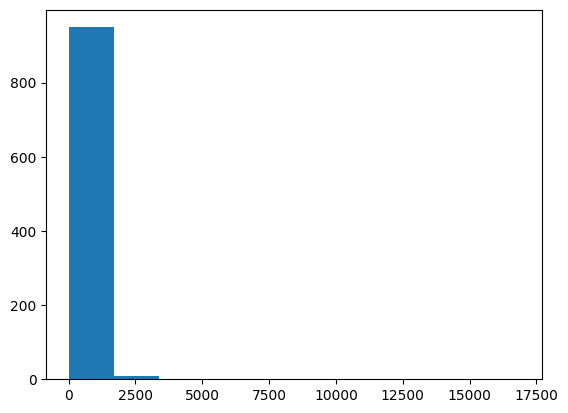

In [18]:
plt.hist(df["TotalGHGEmissions"]);

In [19]:
df["TotalGHGEmissions"].describe()

count      964.000000
mean       193.268672
std        873.974092
min         -0.800000
25%         20.165000
50%         49.215000
75%        140.090000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [20]:
df["TotalGHGEmissions"].quantile([0, .5, 0.98])

0.00      -0.8000
0.50      49.2150
0.98    1008.6684
Name: TotalGHGEmissions, dtype: float64

In [21]:
df = df[df["TotalGHGEmissions"] <= df["TotalGHGEmissions"].quantile([0.98])[0.98]]
df = df[df["TotalGHGEmissions"] > 0]

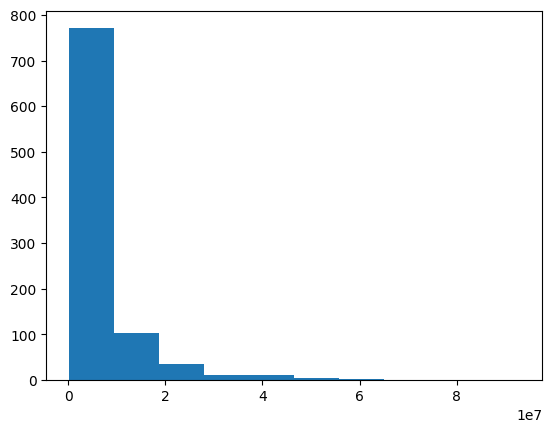

In [22]:
plt.hist(df[label_2]);

In [23]:
df[label_1].describe()

count    942.000000
mean     106.159830
std      145.085844
min        0.810000
25%       19.937500
50%       47.975000
75%      130.575000
max      940.470000
Name: TotalGHGEmissions, dtype: float64

In [24]:
df[label_2].describe()

count    9.420000e+02
mean     6.206883e+06
std      9.461551e+06
min      7.971180e+04
25%      1.236609e+06
50%      2.687720e+06
75%      7.033444e+06
max      9.293764e+07
Name: SiteEnergyUse(kBtu), dtype: float64

## Categorical features

In [25]:
df.BuildingType.nunique(), df.PrimaryPropertyType.nunique(), df.ZipCode.nunique(), df.Neighborhood.nunique(), df.LargestPropertyUseType.nunique()

(4, 16, 38, 18, 19)

In [26]:
def pipe_ohe(df):
    
    #### encoder la colonne LargestPropertyUseType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded = pd.get_dummies(df['LargestPropertyUseType'], prefix='LargestPropertyUseType')
    df = pd.concat([df, onehot_encoded], axis=1)
    df.drop('LargestPropertyUseType', axis=1, inplace=True)
    
    #### encoder la colonne BuildingType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded_BuildingType = pd.get_dummies(df['BuildingType'], prefix='BuildingType')
    df = pd.concat([df, onehot_encoded_BuildingType], axis=1)
    df.drop('BuildingType', axis=1, inplace=True)
    
    ### Remplacer les valeurs 1/0 de LargestPropertyUseType_ par leur % de la surface totale
    # Liste des colonnes à remplacer
    # Boucle pour remplacer les valeurs dans chaque colonne
    cols_to_replace = list(df.filter(like="LargestPropertyUseType_").columns)
    for col in cols_to_replace:
        df[col] = df.apply(lambda row: row["%_LargestPropertyUseType"] if row[col] == 1 else 0, axis=1)    
    df.drop(columns=["%_LargestPropertyUseType"], inplace=True)
    
    return df
    

In [27]:
X = pipe_ohe(df)
y1 = df[[label_1]]
y2 = df[[label_2]]

X_enrg_train, X_enrg_test, y_nrg_train, y_nrg_test = train_test_split(X,y1,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_enrg_train.shape, X_enrg_test.shape)

# séparer la donnée pour avoir les 
X_ghge_train, X_ghge_test, y_ghe_train, y_ghe_test = train_test_split(X,y2,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_ghge_train.shape, X_ghge_test.shape)

(800, 40) (142, 40)
(800, 40) (142, 40)


In [28]:
index_X_enrg_test = X_enrg_test.index
df_nrg_selection = df.loc[index_X_enrg_test]

index_X_ghge_test = X_ghge_test.index
df_ghe_selection = df.loc[index_X_ghge_test]

In [29]:
def pipe(df, means_zipcode=None, 
                means_neighborhood=None,
                means_ppropertype=None, 
                col_for_mean="PropertyGFATotal", 
                scaler=None,
                label_1=label_1,
                label_2=label_2):
    #### encoder la colonne ZipCode ###
    # encoding ZipCode with mean encoding and TotalGHGEmissions #
    # Calculer la moyenne de la colonne cible (label2) pour chaque code postal
    # Encoder la colonne code postal en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    mean_encoding_nan = df[col_for_mean].mean()
    if means_zipcode is None:
        means_zipcode = df.groupby('ZipCode')[col_for_mean].mean()
    df['Code_postal_encoded'] = df['ZipCode'].map(means_zipcode)
    df['Code_postal_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    ### encoder la colonne Neighborhood ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque quartier
    # Encoder la colonne quartier en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    if means_neighborhood is None:
        means_neighborhood = df.groupby('Neighborhood')[col_for_mean].mean()
    df['neighborhood_encoded'] = df['Neighborhood'].map(means_neighborhood)
    df.drop(columns=['Neighborhood'],inplace=True)
    df['neighborhood_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    
    ### encoder la colonne PrimaryPropertyType with mean encoding  ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque PrimaryPropertyType
    # Encoder la colonne PrimaryPropertyType en fonction de la moyenne de la colonne cible
    # Supprimer la colonne catégorielle
    if means_ppropertype is None:
        means_ppropertype = df.groupby('PrimaryPropertyType')[col_for_mean].mean()
    df['PrimaryPropertyType_encoded'] = df['PrimaryPropertyType'].map(means_ppropertype)
    df.drop(columns=['PrimaryPropertyType'],inplace=True)
    df['PrimaryPropertyType_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    #supprimer les labels du jeu de données
    df = df.drop(columns=[label_1,label_2])
    df.drop(columns=['SourceEUI(kBtu/sf)', 'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)
    
    #scaler
    # if scaler is None:
    #     scaler=StandardScaler()
    #     df_scaled = scaler.fit_transform(df)
    #     print("check scaler standard scaler")
    # else:
    #     df_scaled = scaler.transform(df)
    #     print("check scaler the train scaler")
    
    return df, means_zipcode, means_neighborhood, means_ppropertype, df.columns
    

In [30]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'Neighborhood',
       'Building_age', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', '%_LargestPropertyUseType',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       '%_GFAParking', '%_GFABuilding', 'Nb_PropertyUseTypes'],
      dtype='object')

In [31]:
X_nrg_train, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, columns_enrg = pipe(X_enrg_train,col_for_mean=label_1)
X_nrg_test, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, a = pipe(X_enrg_test,
                                                                        means_zipcode=means_zipcode_enrg,
                                                                        means_neighborhood=means_neighborhood_enrg,
                                                                        means_ppropertype=means_ppropertype_enrg,
                                                                        col_for_mean=label_1)

Index(['PrimaryPropertyType', 'ZipCode', 'Neighborhood', 'Building_age',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', '%_GFAParking',
       '%_GFABuilding', 'Nb_PropertyUseTypes',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_Data Center',
       'LargestPropertyUseType_Distribution Center',
       'LargestPropertyUseType_Financial Office',
       'LargestPropertyUseType_Hotel', 'LargestPropertyUseType_K-12 School',
       'LargestPropertyUseType_Medical Office',
       'LargestPropertyUseType_Multifamily Housing',
       'LargestPropertyUseType_Non-Refrigerated Warehouse',
       'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other',
       'LargestPropertyUseType_Parking',
       'LargestPropertyUseType_Refrigerated Warehouse',
       'LargestProperty

In [32]:
X_ghe_train, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, columns_ghe = pipe(X_ghge_train,col_for_mean=label_2)
X_ghe_test, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, b = pipe(X_ghge_test, 
                                                                        means_zipcode=means_zipcode_ghe,
                                                                        means_neighborhood=means_neighborhood_ghe,
                                                                        means_ppropertype=means_ppropertype_ghe,
                                                                        col_for_mean=label_2)

Index(['PrimaryPropertyType', 'ZipCode', 'Neighborhood', 'Building_age',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', '%_GFAParking',
       '%_GFABuilding', 'Nb_PropertyUseTypes',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_Data Center',
       'LargestPropertyUseType_Distribution Center',
       'LargestPropertyUseType_Financial Office',
       'LargestPropertyUseType_Hotel', 'LargestPropertyUseType_K-12 School',
       'LargestPropertyUseType_Medical Office',
       'LargestPropertyUseType_Multifamily Housing',
       'LargestPropertyUseType_Non-Refrigerated Warehouse',
       'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other',
       'LargestPropertyUseType_Parking',
       'LargestPropertyUseType_Refrigerated Warehouse',
       'LargestProperty

In [33]:
print(X_nrg_train.shape, X_nrg_test.shape), 
print(X_ghe_train.shape, X_ghe_test.shape)

(800, 35) (142, 35)
(800, 35) (142, 35)


## Modèles

###  Results functions

In [34]:
def results_printed(model):
    # Best score                     
    print(f"Best score : {model.best_score_}")
    
    # Best Params
    print(f"Best params :\n {model.best_params_}")

In [35]:
metrics_df_nrg = pd.DataFrame(columns=["label","modèle","r2_train","r2_test","mae","rmse","mean_fit_time","best_params"])
metrics_df_ghe = pd.DataFrame(columns=["label","modèle","r2_train","r2_test","mae","rmse","mean_fit_time","best_params"])

def add_metrics_table(label,y_pred,y_test,df,model):
    r2_train = round(model.score(y_test,y_pred),4)
    r2_test = round(r2_score(y_test, y_pred), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = round(mean_squared_error(y_test, y_pred), 4)
    df = df.append({
    "label": label,
    "modèle": model.best_estimator_,
    "r2_train":'{:.3f}'.format(r2_train),
    "r2_test": '{:.3f}'.format(r2_test),
    "mae": '{:.3f}'.format(mae),
    "rmse": '{:.3f}'.format(rmse),
    "mean_fit_time": model.cv_results_['mean_fit_time'].mean(),
    "best_params": model.best_params_
    }, ignore_index=True)
    return df

scoring = ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

def evaluate_prediction(label, X_test, y_test, metrics_df, model):
    y_pred = model.predict(X_test)

    metrics_df = add_metrics_table(label,y_pred,y_test,metrics_df,model)

    # Créer le scatter plot
    plt.scatter(y_pred, y_test)

    # Ajouter une ligne diagonale pour représenter la ligne de prédiction parfaite
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    # Ajouter des labels pour les axes et le titre du plot
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Comparaison des prédictions et des valeurs réelles')

    # Afficher le plot
    plt.show()
    display(metrics_df)
    return metrics_df, y_pred

In [36]:
def hist_errors(y_test, y_pred):
    y_test = np.array(y_test).reshape(-1,)
    diff = y_test - y_pred
    mean = diff.mean()
    std = diff.std()
    plt.hist(diff, bins=40)
    plt.vlines(mean, 0, 30, color='red', label=f'mean = {mean:.2f}')
    plt.hlines(30, mean - 1/2 * std, mean + 1/2 * std, color='red', label=f'std = {std:.2f}', ls='dotted')
    plt.title('Histogram of prediction errors')
    plt.xlabel('prediction error')
    plt.ylabel('Frequency')
    
    # Showing the legend
    plt.legend(loc='upper right')
    plt.show()

In [37]:
def show_fetures_coef(model, columns):
    coef = model.best_estimator_.coef_
    if coef.ndim == 2 and coef.shape[0] == 1:
        coef = coef[0]
    features_coef = pd.DataFrame(coef.reshape(1,-1), columns=list(columns))
    columns = list(reversed(features_coef.columns))
    coef = list(reversed(coef))
    
    
    plt.figure(figsize=(14,8))
    # Créer un graphique à barres horizontales
    plt.barh(columns, coef)

    # Récupérer les étiquettes de l'axe des abscisses
    labels = plt.gca().get_yticklabels()

    # Parcourir les étiquettes et appliquer un style différent aux étiquettes non nulles
    for label, value in zip(labels, coef):
        if value != -0:
            label.set_color('red')  # Appliquer une couleur rouge aux étiquettes non nulles
        else:
            label.set_color('black')  # Appliquer une couleur noire aux étiquettes nulles

    plt.show()

In [38]:
def error_per_category(df, y_test, y_pred, feature):
    df["error_pred"] = (np.array(y_test).reshape(-1,) - y_pred)
    df_grouped = df.groupby(feature).mean()['error_pred']
    counts = df[feature].value_counts()

    # Créer le graphique montrant la moyenne des erreurs et le nombre d'occurrences
    fig, ax = plt.subplots()

    # Afficher les barres de la moyenne des erreurs
    ax.bar(df_grouped.index, df_grouped.values)

    # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
    for i, v in enumerate(df_grouped.values):
        ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

    # Ajouter une légende
    ax.text(0.05, -0.2, f'{counts[df_grouped.index[i]]}:Nombre d\'occurrences dans le jeu de test', transform=ax.transAxes)

    ax.set_xlabel(feature)
    ax.set_ylabel('Moyenne des erreurs')

    # Changer la taille de la figure
    fig.set_size_inches(8, 4)
    
    # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
    ax.margins(y=0.1)
    
    plt.show()

In [39]:
def error_all_category(df, y_test, y_pred, features):
    # Créer une figure avec des subplots
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)), gridspec_kw={'hspace': 0.6})
    axs[0].set_ylabel('Moyenne des erreurs')

    # Boucle sur les features
    for i, feature in enumerate(features):
        # Récupérer l'axe courant
        ax = axs[i]

        # Calculer les erreurs moyennes pour chaque catégorie
        df["error_pred"] = abs((np.array(y_test).reshape(-1,) - y_pred))
        df_grouped = df.groupby(feature).mean()['error_pred']
        counts = df_nrg_selection[feature].value_counts()

        # Afficher les barres de la moyenne des erreurs
        ax.bar(df_grouped.index, df_grouped.values)

        # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
        for i, v in enumerate(df_grouped.values):
            ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

        # Ajouter un titre pour chaque subplot
        ax.set_title(feature)

        # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
        ax.margins(y=0.1)
        
        # Ajouter des étiquettes d'axe plus petites et penchées
        ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)

    # Ajouter un titre pour le graphique global
    fig.suptitle('Erreurs en fonction des variables catégorielles', y=0.95, fontsize=16)

    # Afficher le graphique
    plt.show()


In [40]:
def error_discrete_feature(df, col):
    # Créer un graphique en nuage de points pour représenter les erreurs
    fig, ax = plt.subplots()
    ax.scatter(df[col], df['error_pred'], label=col)

    # Ajouter les labels des axes et la légende
    ax.set_xlabel(col)
    ax.set_ylabel('error_pred')

    plt.show()

In [41]:
def error_all_discr_category(df, y_test, y_pred, features):
    # Créer une figure avec des subplots
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)), gridspec_kw={'hspace': 0.3})

    # Calculer les erreurs moyennes pour chaque catégorie
    df["error_pred"] = abs((np.array(y_test).reshape(-1,) - y_pred))
        
    # Boucle sur les features
    for i, feature in enumerate(features):
        # Récupérer l'axe courant
        ax = axs[i]

        ax.scatter(df[feature], df['error_pred'], label=feature)

        # Ajouter un titre pour chaque subplot
        ax.set_title(feature)

    # Ajouter un titre pour le graphique global
    fig.suptitle('Erreurs en fonction des variables catégorielles', y=0.92, fontsize=16)

    # Afficher le graphique
    plt.show()

disc_col_viz = ["Building_age","%_GFAParking","%_GFABuilding","LargestPropertyUseTypeGFA","NumberofBuildings","NumberofFloors"]

### Pipeline with a scaler

## Label 1 : energy

### Dummy regression

In [ ]:
dummy_regr = DummyRegressor()
parameters = {"strategy" : ("mean","median","quantile"),
            "quantile" : [0.25,0.5,0.75]}
grid_dummy_nrg = GridSearchCV(dummy_regr, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit = "r2")
grid_dummy_nrg.fit(X_nrg_train, y_nrg_train)

GridSearchCV(cv=5, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'quantile': [0.25, 0.5, 0.75],
                         'strategy': ('mean', 'median', 'quantile')},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

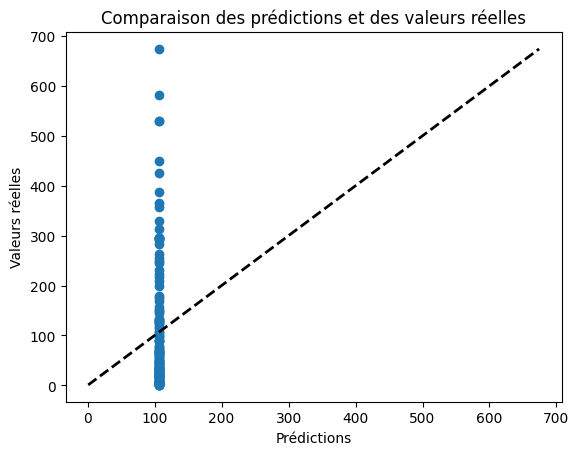

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"


In [ ]:
metrics_df_nrg, y_pred_dummy = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_dummy_nrg)

### Linear Regression

In [ ]:
reg = LinearRegression()
parameters = {'fit_intercept': [True, False]}
grid_reglin_nrg = GridSearchCV(reg,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_reglin_nrg.fit(X_nrg_train, y_nrg_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

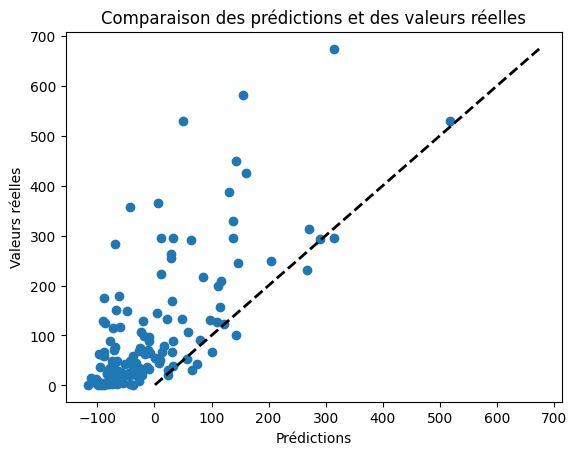

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.008409,{'fit_intercept': False}


In [ ]:
metrics_df_nrg, y_pred_reg = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_reglin_nrg)

### Lasso Regression

In [ ]:
lasso = Lasso(random_state=42)
alpha_space = np.logspace(-4, 2, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_lasso_nrg = GridSearchCV(lasso, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lasso_nrg.fit(X_nrg_train, y_nrg_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 2.68269580e-04, 7.19685673e-04, 1.93069773e-03,
       5.17947468e-03, 1.38949549e-02, 3.72759372e-02, 1.00000000e-01,
       2.68269580e-01, 7.19685673e-01, 1.93069773e+00, 5.17947468e+00,
       1.38949549e+01, 3.72759372e+01, 1.00000000e+02])},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

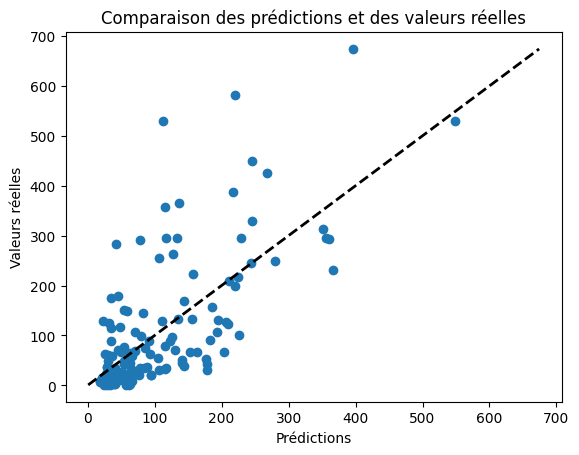

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.008409,{'fit_intercept': False}
2,TotalGHGEmissions,"Lasso(alpha=5.1794746792312125, random_state=42)",0.4983,62.1181,8509.2724,0.011452,{'alpha': 5.1794746792312125}


In [ ]:
metrics_df_nrg, y_pred_lasso = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_lasso_nrg)

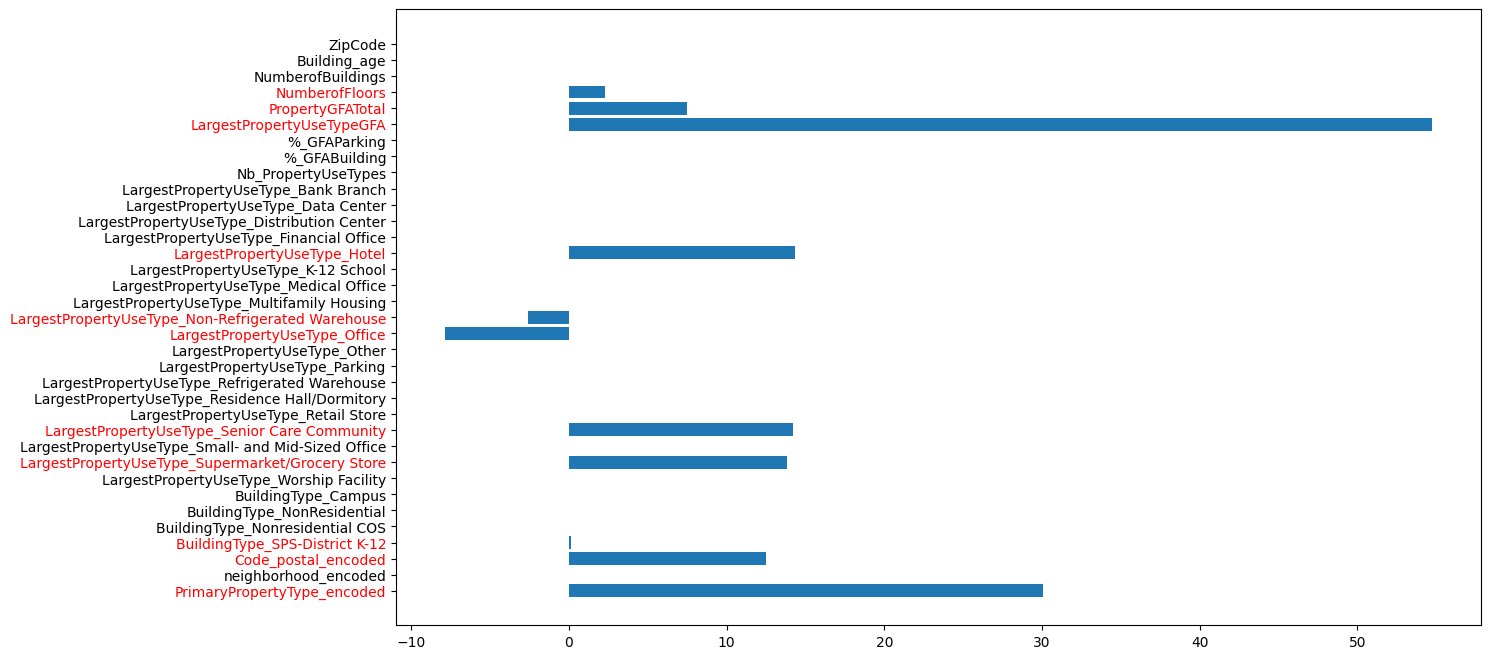

In [ ]:
show_fetures_coef(grid_lasso_nrg, columns_enrg)

### Ridge regression

In [ ]:
ridge = Ridge(random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_ridge_nrg = GridSearchCV(ridge, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_ridge_nrg.fit(X_nrg_train, y_nrg_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 3.72759372e-05, 1.38949549e-04, 5.17947468e-04,
       1.93069773e-03, 7.19685673e-03, 2.68269580e-02, 1.00000000e-01,
       3.72759372e-01, 1.38949549e+00, 5.17947468e+00, 1.93069773e+01,
       7.19685673e+01, 2.68269580e+02, 1.00000000e+03])},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

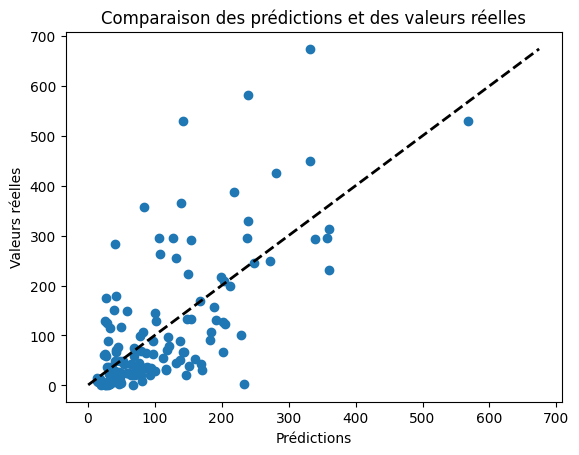

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.008409,{'fit_intercept': False}
2,TotalGHGEmissions,"Lasso(alpha=5.1794746792312125, random_state=42)",0.4983,62.1181,8509.2724,0.011452,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,"Ridge(alpha=268.26957952797216, random_state=42)",0.4899,63.2777,8651.4328,0.011962,{'alpha': 268.26957952797216}


In [ ]:
metrics_df_nrg, y_pred_ridge = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_ridge_nrg)

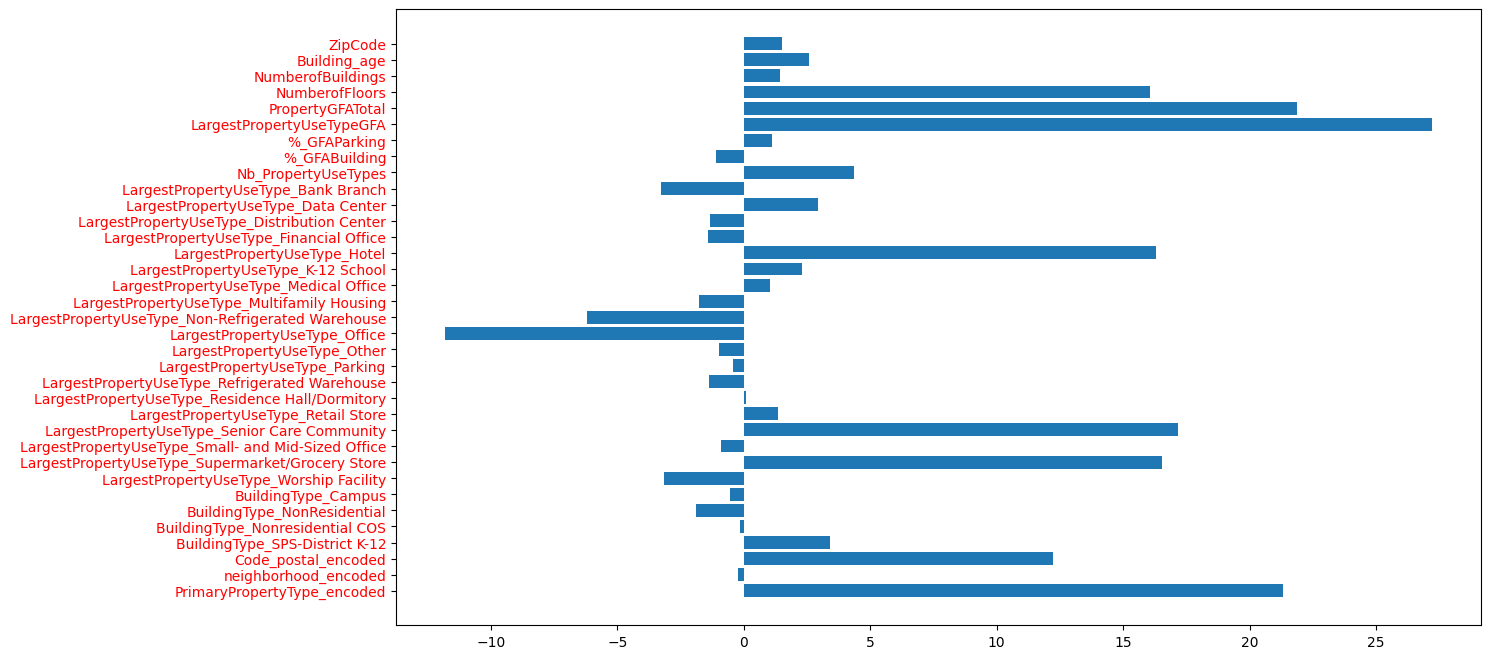

In [ ]:
show_fetures_coef(grid_ridge_nrg, columns_enrg)

### Elastic Net

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.411e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e+06, tolerance: 1.584e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

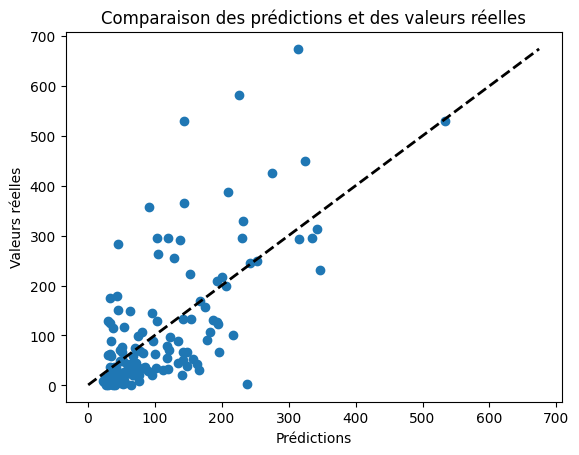

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.008409,{'fit_intercept': False}
2,TotalGHGEmissions,"Lasso(alpha=5.1794746792312125, random_state=42)",0.4983,62.1181,8509.2724,0.011452,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,"Ridge(alpha=268.26957952797216, random_state=42)",0.4899,63.2777,8651.4328,0.011962,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.199599,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."


In [ ]:
elnet = ElasticNet(max_iter=20000,random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
l1_space = np.logspace(-3, 0, 15)
parameters = {"alpha" : alpha_space,
            "l1_ratio" : l1_space}
grid_elnet_nrg = GridSearchCV(elnet, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_elnet_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_elnet = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_elnet_nrg)

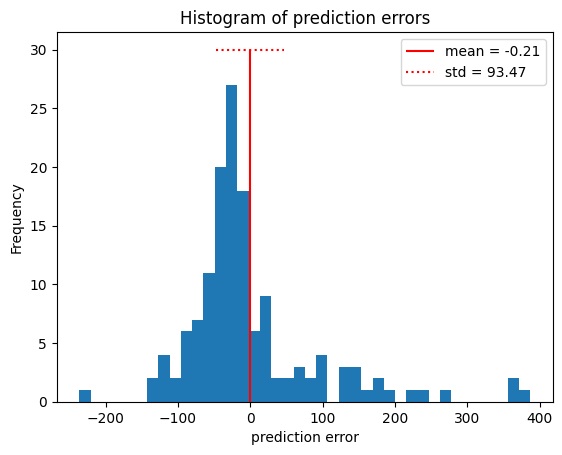

In [ ]:
hist_errors(y_nrg_test, y_pred_elnet)

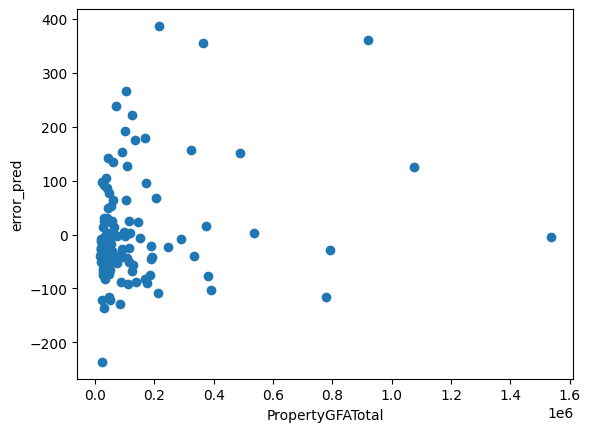

In [ ]:
error_discrete_feature(df_nrg_selection, 'PropertyGFATotal')

In [ ]:
cat_features_next = ['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType']

/var/folders/t8/clhcfp2n5sgcs4b81syf8xym0000gp/T/ipykernel_9495/2828427138.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)


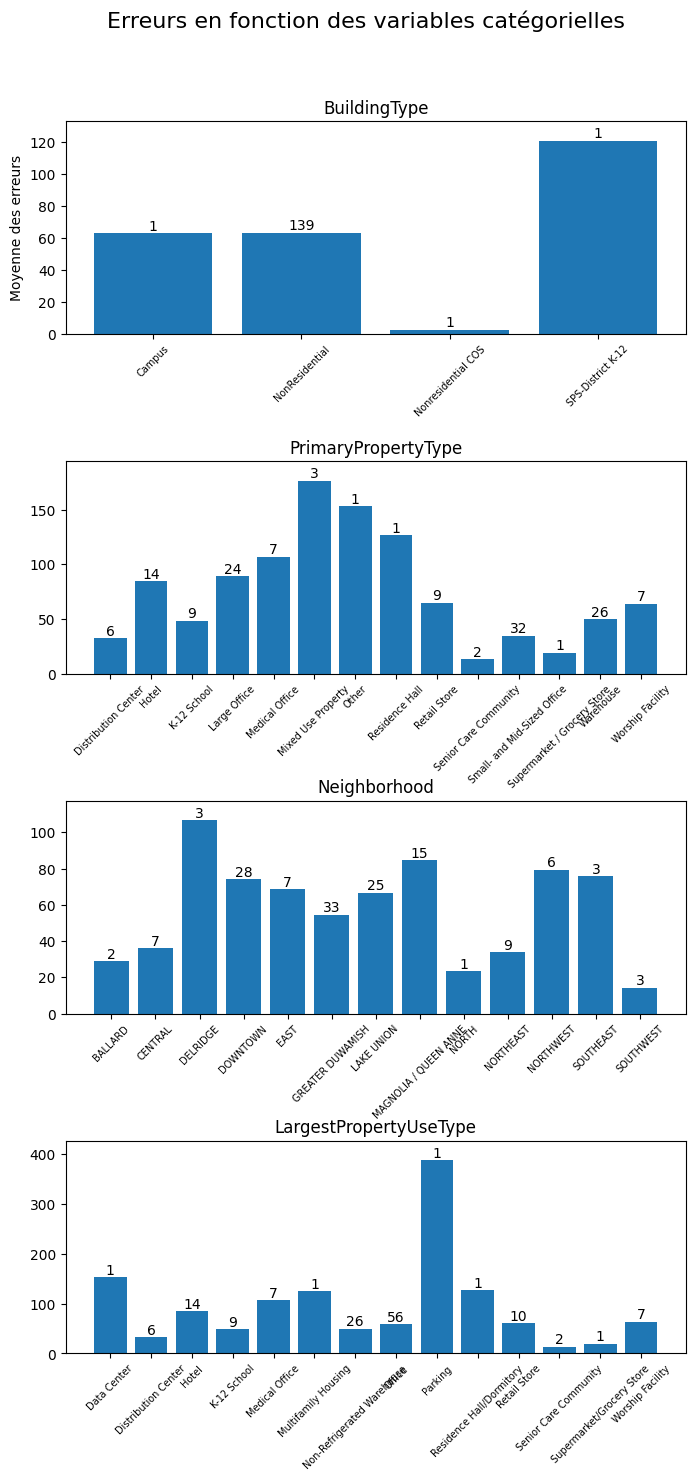

In [ ]:
# Créer une figure avec des subplots
fig, axs = plt.subplots(nrows=len(cat_features_next), ncols=1, figsize=(8, 4 * len(cat_features_next)), gridspec_kw={'hspace': 0.6})
axs[0].set_ylabel('Moyenne des erreurs')

# Boucle sur les features
for i, feature in enumerate(cat_features_next):
    # Récupérer l'axe courant
    ax = axs[i]

    # Calculer les erreurs moyennes pour chaque catégorie
    df_nrg_selection["error_pred"] = abs((np.array(y_nrg_test).reshape(-1,) - y_pred_elnet))
    df_grouped = df_nrg_selection.groupby(feature).mean()['error_pred']
    counts = df_nrg_selection[feature].value_counts()

    # Afficher les barres de la moyenne des erreurs
    ax.bar(df_grouped.index, df_grouped.values)

    # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
    for i, v in enumerate(df_grouped.values):
        ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

    # Ajouter un titre pour chaque subplot
    ax.set_title(feature)

    # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
    ax.margins(y=0.1)
    
    # Ajouter des étiquettes d'axe plus petites et penchées
    ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)

# Ajouter un titre pour le graphique global
fig.suptitle('Erreurs en fonction des variables catégorielles', y=0.95, fontsize=16)

# Afficher le graphique
plt.show()


### Decision tree Regressor

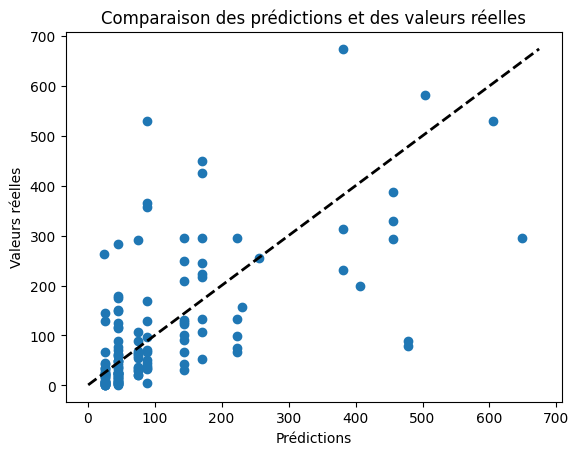

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.008409,{'fit_intercept': False}
2,TotalGHGEmissions,"Lasso(alpha=5.1794746792312125, random_state=42)",0.4983,62.1181,8509.2724,0.011452,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,"Ridge(alpha=268.26957952797216, random_state=42)",0.4899,63.2777,8651.4328,0.011962,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.199599,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,"DecisionTreeRegressor(max_depth=5, random_stat...",0.3039,67.9186,11806.2271,0.010827,"{'max_depth': 5, 'min_samples_leaf': 1}"


In [ ]:
dectree = DecisionTreeRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3],
            'max_depth': range(5,10)}

grid_dectree_nrg = GridSearchCV(dectree, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dectree_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_dectree = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_dectree_nrg)

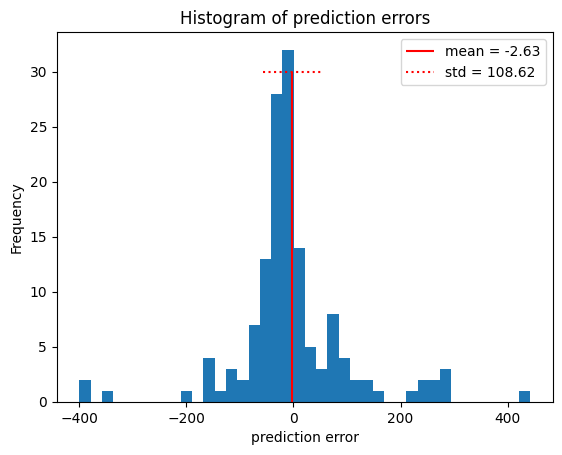

In [ ]:
hist_errors(y_nrg_test, y_pred_dectree)

### RandomForestRegressor

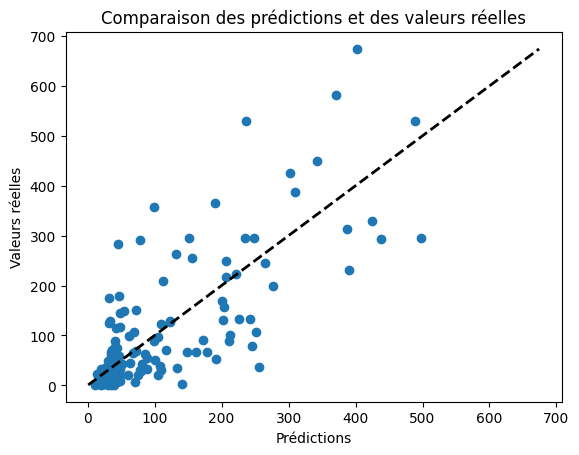

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.008409,{'fit_intercept': False}
2,TotalGHGEmissions,"Lasso(alpha=5.1794746792312125, random_state=42)",0.4983,62.1181,8509.2724,0.011452,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,"Ridge(alpha=268.26957952797216, random_state=42)",0.4899,63.2777,8651.4328,0.011962,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.199599,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,"DecisionTreeRegressor(max_depth=5, random_stat...",0.3039,67.9186,11806.2271,0.010827,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.5788,58.0326,7144.5700,1.462669,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4692,58.8869,9003.1031,0.418022,{}
8,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.5788,58.0326,7144.5700,1.258727,"{'criterion': 'absolute_error', 'max_features'..."


In [ ]:
randomforest = RandomForestRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3],
            'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'max_features': [0.3,0.5,0.75,1,"sqrt","log2"]}

grid_randomforest_nrg = GridSearchCV(randomforest, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_nrg.fit(X_nrg_train, y_nrg_train.values.ravel())

metrics_df_nrg, y_pred_randomforest = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_randomforest_nrg)

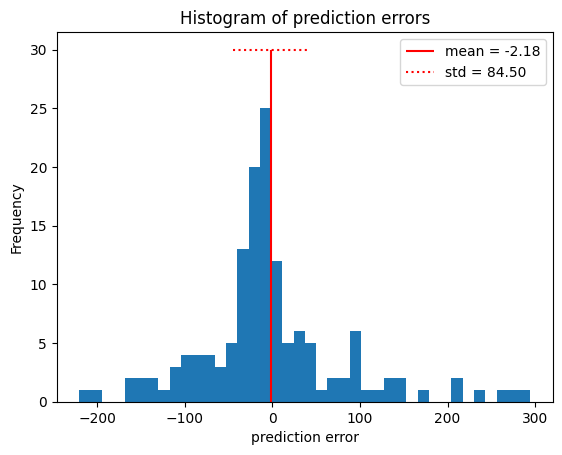

In [ ]:
hist_errors(y_nrg_test, y_pred_randomforest)

### XGboost

In [45]:
X_nrg_train.shape

(800, 35)

In [48]:
# Créer le ColumnTransformer pour gérer les différentes colonnes avec des normalizers
# Définir les normalizers à tester
scalers = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('MaxAbsScaler', MaxAbsScaler())
]

# Définir les paramètres pour le GridSearchCV
parameters = {
    'scaler': [scaler for _, scaler in scalers]
}

# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', xgboost.XGBRegressor(random_state=42))
])

grid_xgboost_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_xgboost = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_xgboost_nrg)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- TotalGHGEmissions
Feature names seen at fit time, yet now missing:
- %_GFABuilding
- %_GFAParking
- BuildingType_Campus
- BuildingType_NonResidential
- BuildingType_Nonresidential COS
- ...


In [49]:
grid_xgboost_nrg.score(X_nrg_test, y_nrg_test)

0.46917861628069535

In [ ]:
XGboost = xgboost.XGBRegressor(random_state=42)
eta = np.logspace(-5, 0.3, 5)
L1_reg = np.logspace(-10, 10, 5)
L2_reg = np.logspace(-10, 10, 5)
parameters = {'max_depth': [3,7,11],
            'learning_rate': eta,
            'reg_alpha': L1_reg,
            'reg_lambda' : L2_reg,
            'colsample_bytree' : [0.25,0.5,0.75,1]
            }

grid_xgboost_nrg = GridSearchCV(XGboost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_nrg.fit(X_nrg_train, y_nrg_train)

#metrics_df_nrg, y_pred_xgboost = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_xgboost_nrg)

NameError: name 'xgboost' is not defined

In [ ]:
pd.set_option('display.max_colwidth', 500)
metrics_df_nrg

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.005776,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.008409,{'fit_intercept': False}
2,TotalGHGEmissions,"Lasso(alpha=5.1794746792312125, random_state=42)",0.4983,62.1181,8509.2724,0.011452,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,"Ridge(alpha=268.26957952797216, random_state=42)",0.4899,63.2777,8651.4328,0.011962,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0.6105402296585326, max_iter=20000,\n random_state=42)",0.4849,63.4031,8736.8212,0.199599,"{'alpha': 1.389495494373136, 'l1_ratio': 0.6105402296585326}"
5,TotalGHGEmissions,"DecisionTreeRegressor(max_depth=5, random_state=42)",0.3039,67.9186,11806.2271,0.010827,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,"(DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=1608637542), DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=1273642419), DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=1935803228), DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=787846414), DecisionTreeRegr...",0.5788,58.0326,7144.5700,1.462669,"{'criterion': 'absolute_error', 'max_features': 'sqrt', 'min_samples_leaf': 1}"
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,\n grow_policy='depthwise', importance_type=None,\n interaction_constraints='', learning_rate=0.300000012, max_bin=256,\n max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,\...",0.4692,58.8869,9003.1031,0.418022,{}
8,TotalGHGEmissions,"(DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=1608637542), DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=1273642419), DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=1935803228), DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',\n random_state=787846414), DecisionTreeRegr...",0.5788,58.0326,7144.5700,1.258727,"{'criterion': 'absolute_error', 'max_features': 'sqrt', 'min_samples_leaf': 1}"
9,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False, eta=0.1,\n eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,\n grow_policy='depthwise', importance_type=None,\n interaction_constraints='', learning_rate=0.100000001, max_bin=256,\n max_cat_threshold=64, max_cat_to_onehot=4, max_delta...",0.5183,58.0902,8169.7289,0.400253,"{'eta': 0.1, 'max_depth': 3, 'max_features': 0.5, 'reg_alpha': 268.26957952797216}"


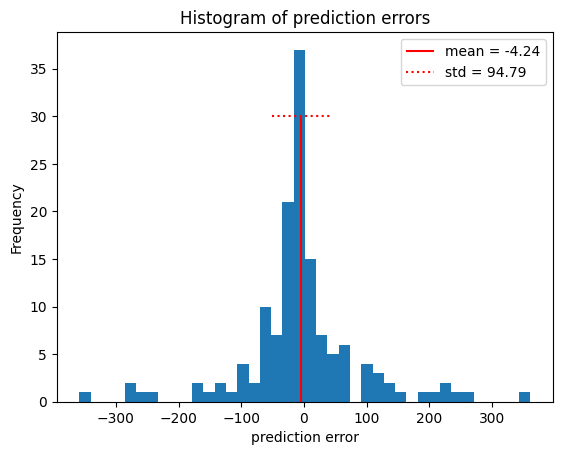

In [ ]:
hist_errors(y_nrg_test, y_pred_xgboost)

### LightBoost

lightboost = LGBMRegressor(random_state=42)
parameters = {'n_estimators': range(1000,1500,100),
            'learning_rate': [0.01,0.001,0.03,0.1,0.3]}

grid_lightboost_nrg = GridSearchCV(lightboost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lightboost_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_lgboost = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_lightboost_nrg)

## Label 2 - GHE

### Dummy Regression

In [ ]:
dummy_regr = DummyRegressor()
parameters = {"strategy" : ("mean","median")}
grid_dummy_ghe = GridSearchCV(dummy_regr, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dummy_ghe.fit(X_ghe_train, y_ghe_train)

GridSearchCV(cv=5, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'strategy': ('mean', 'median')}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

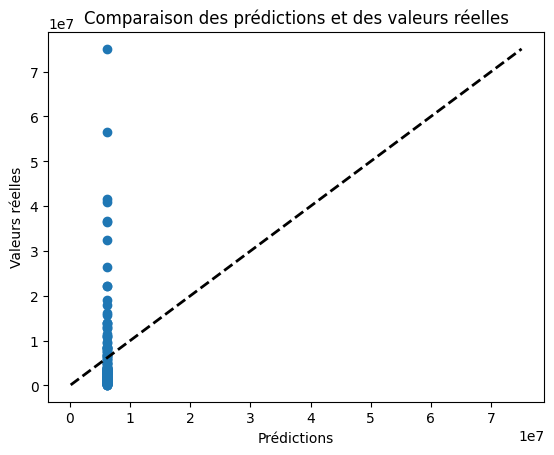

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}


In [ ]:
metrics_df_ghe, y_pred_dummy_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_dummy_ghe)

### Linear Regression

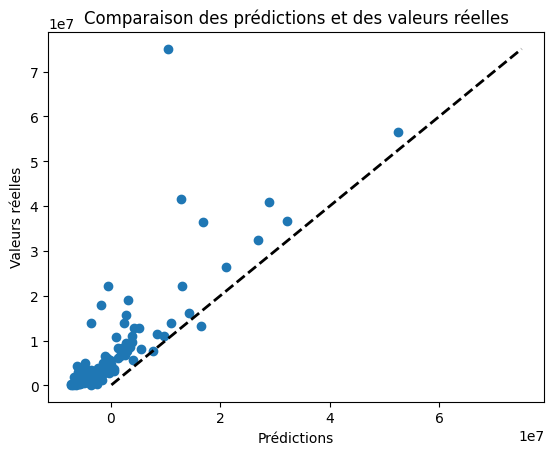

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}
1,SiteEnergyUse(kBtu),LinearRegression(fit_intercept=False),0.2613,6817892.8088,83486928297603.5469,0.008165,{'fit_intercept': False}


In [ ]:
parameters = {'fit_intercept': [True, False]}
grid_reglin_ghe = GridSearchCV(reg,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_reglin_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_reg_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_reglin_ghe)

### Lasso Regression

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.755e+14, tolerance: 5.490e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e+14, tolerance: 6.029e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

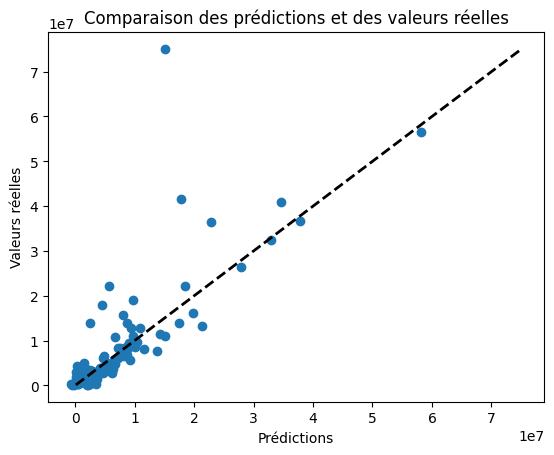

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}
1,SiteEnergyUse(kBtu),LinearRegression(fit_intercept=False),0.2613,6817892.8088,83486928297603.5469,0.008165,{'fit_intercept': False}
2,SiteEnergyUse(kBtu),"Lasso(alpha=100000.0, max_iter=10000, random_s...",0.6534,2430017.7020,39170430220874.3672,0.187429,{'alpha': 100000.0}


In [ ]:
lasso = Lasso(max_iter=10000, tol=0.0001,random_state=42)
alpha_space = np.logspace(-5, 5, 15)   # Checking for alpha from .0001 to 10000 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_lasso_ghe = GridSearchCV(lasso, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lasso_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_lasso_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_lasso_ghe)

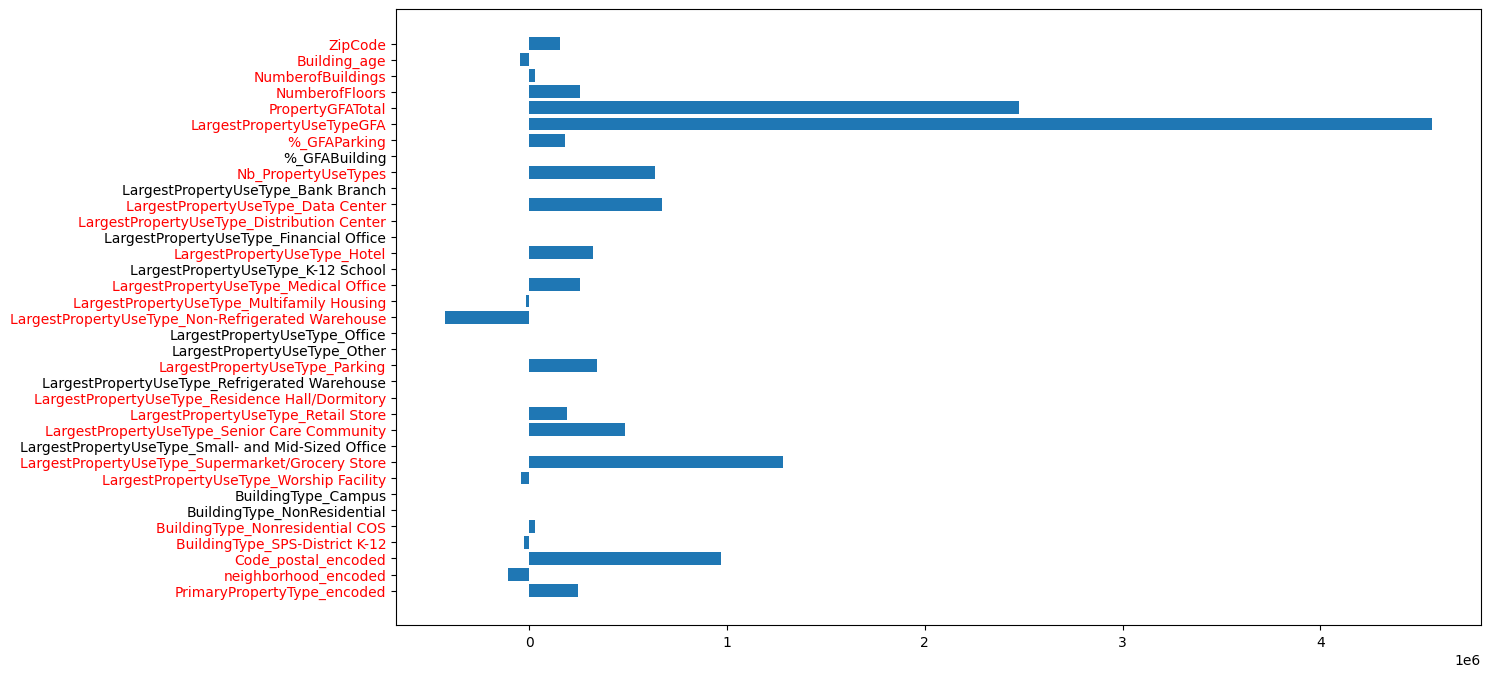

In [ ]:
show_fetures_coef(grid_lasso_ghe, columns_ghe)

### vérification du scaling des données

ValueError: num must be 1 <= num <= 35, not 36

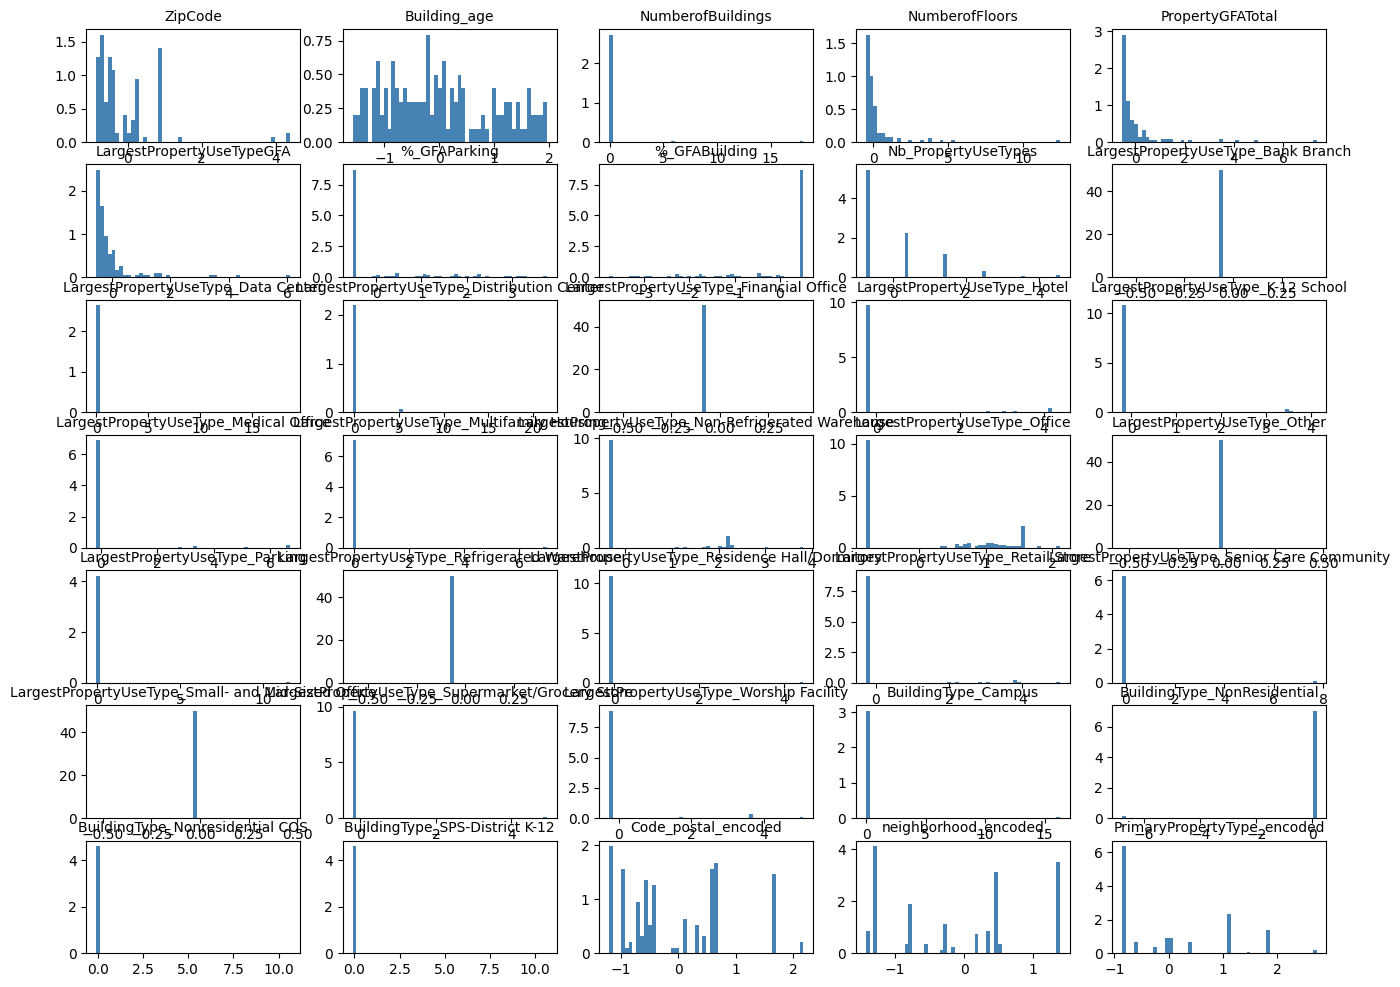

In [ ]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_enrg_test.shape[1]):
    ax = fig.add_subplot(7,5, (feat_idx+1))
    h = ax.hist(X_nrg_test[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(columns_enrg[feat_idx], fontsize=10)

### Ridge 

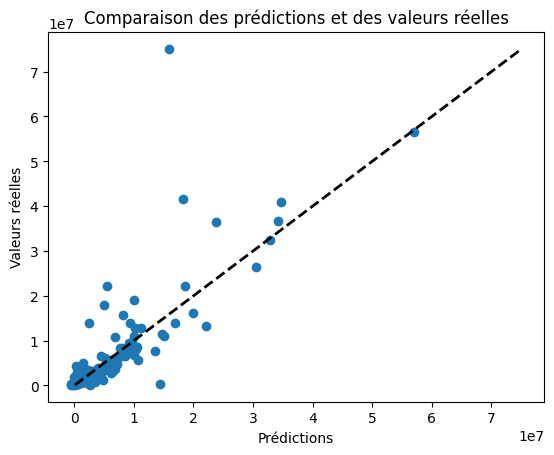

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}
1,SiteEnergyUse(kBtu),LinearRegression(fit_intercept=False),0.2613,6817892.8088,83486928297603.5469,0.008165,{'fit_intercept': False}
2,SiteEnergyUse(kBtu),"Lasso(alpha=100000.0, max_iter=10000, random_s...",0.6534,2430017.7020,39170430220874.3672,0.187429,{'alpha': 100000.0}
3,SiteEnergyUse(kBtu),"Ridge(alpha=71.96856730011514, random_state=42)",0.6471,2574982.9122,39885986077285.5938,0.009160,{'alpha': 71.96856730011514}


In [ ]:
ridge = Ridge(random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_ridge_ghe = GridSearchCV(ridge, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_ridge_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_ridge_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_ridge_ghe)

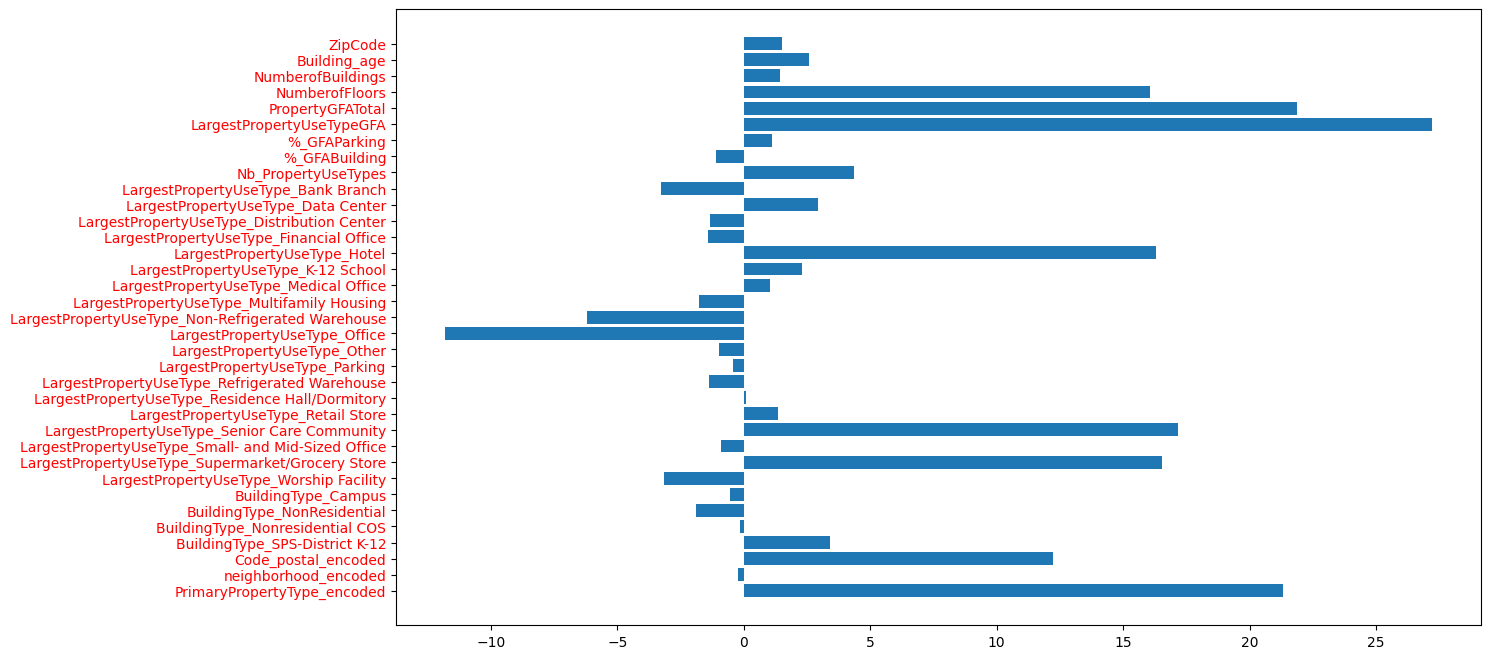

In [ ]:
show_fetures_coef(grid_ridge_nrg, columns_enrg)

### Elastic Net

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.067e+15, tolerance: 5.490e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e+15, tolerance: 5.710e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

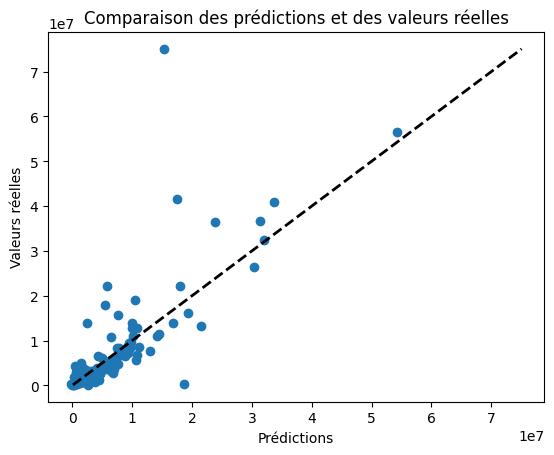

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}
1,SiteEnergyUse(kBtu),LinearRegression(fit_intercept=False),0.2613,6817892.8088,83486928297603.5469,0.008165,{'fit_intercept': False}
2,SiteEnergyUse(kBtu),"Lasso(alpha=100000.0, max_iter=10000, random_s...",0.6534,2430017.7020,39170430220874.3672,0.187429,{'alpha': 100000.0}
3,SiteEnergyUse(kBtu),"Ridge(alpha=71.96856730011514, random_state=42)",0.6471,2574982.9122,39885986077285.5938,0.009160,{'alpha': 71.96856730011514}
4,SiteEnergyUse(kBtu),"ElasticNet(alpha=0.3727593720314938, l1_ratio=...",0.6300,2673886.5652,41817911246886.8047,0.273776,"{'alpha': 0.3727593720314938, 'l1_ratio': 0.37..."


In [ ]:
elnet = ElasticNet(max_iter=20000,random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
l1_space = np.logspace(-3, 0, 15)
parameters = {"alpha" : alpha_space,
            "l1_ratio" : l1_space}
grid_elnet_ghe = GridSearchCV(elnet, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_elnet_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_elnet_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_elnet_ghe)

### Decision tree Regressor

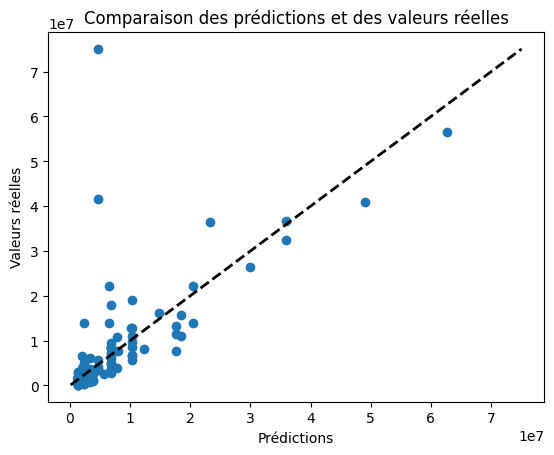

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}
1,SiteEnergyUse(kBtu),LinearRegression(fit_intercept=False),0.2613,6817892.8088,83486928297603.5469,0.008165,{'fit_intercept': False}
2,SiteEnergyUse(kBtu),"Lasso(alpha=100000.0, max_iter=10000, random_s...",0.6534,2430017.7020,39170430220874.3672,0.187429,{'alpha': 100000.0}
3,SiteEnergyUse(kBtu),"Ridge(alpha=71.96856730011514, random_state=42)",0.6471,2574982.9122,39885986077285.5938,0.009160,{'alpha': 71.96856730011514}
4,SiteEnergyUse(kBtu),"ElasticNet(alpha=0.3727593720314938, l1_ratio=...",0.6300,2673886.5652,41817911246886.8047,0.273776,"{'alpha': 0.3727593720314938, 'l1_ratio': 0.37..."
5,SiteEnergyUse(kBtu),"DecisionTreeRegressor(max_depth=5, min_samples...",0.5111,2711822.9877,55248793360970.8828,0.012610,"{'max_depth': 5, 'min_samples_leaf': 5}"


In [ ]:
dectree = DecisionTreeRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3,4,5],
            'max_depth': range(5,10)}

grid_dectree_ghe = GridSearchCV(dectree, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dectree_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_dectree_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_dectree_ghe)

### RandomForest

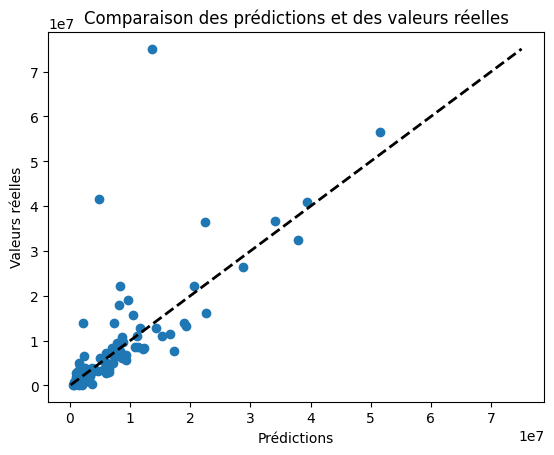

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}
1,SiteEnergyUse(kBtu),LinearRegression(fit_intercept=False),0.2613,6817892.8088,83486928297603.5469,0.008165,{'fit_intercept': False}
2,SiteEnergyUse(kBtu),"Lasso(alpha=100000.0, max_iter=10000, random_s...",0.6534,2430017.7020,39170430220874.3672,0.187429,{'alpha': 100000.0}
3,SiteEnergyUse(kBtu),"Ridge(alpha=71.96856730011514, random_state=42)",0.6471,2574982.9122,39885986077285.5938,0.009160,{'alpha': 71.96856730011514}
4,SiteEnergyUse(kBtu),"ElasticNet(alpha=0.3727593720314938, l1_ratio=...",0.6300,2673886.5652,41817911246886.8047,0.273776,"{'alpha': 0.3727593720314938, 'l1_ratio': 0.37..."
5,SiteEnergyUse(kBtu),"DecisionTreeRegressor(max_depth=5, min_samples...",0.5111,2711822.9877,55248793360970.8828,0.012610,"{'max_depth': 5, 'min_samples_leaf': 5}"
6,SiteEnergyUse(kBtu),(DecisionTreeRegressor(criterion='absolute_err...,0.5972,2460740.5346,45524550505914.6719,1.178947,"{'criterion': 'absolute_error', 'max_features'..."
7,SiteEnergyUse(kBtu),"XGBRegressor(base_score=0.5, booster='gbtree',...",0.6775,2567150.8454,36444709037842.6641,0.660242,{}
8,SiteEnergyUse(kBtu),(DecisionTreeRegressor(criterion='absolute_err...,0.5972,2460740.5346,45524550505914.6719,1.179386,"{'criterion': 'absolute_error', 'max_features'..."


In [ ]:
randomforest = RandomForestRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3],
            'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'max_features': [0.3,0.5,0.75,1,"sqrt","log2"]}

grid_randomforest_ghe = GridSearchCV(randomforest, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_ghe.fit(X_ghe_train, y_ghe_train.values.ravel())

metrics_df_ghe, y_pred_forest_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_randomforest_ghe)

### XGBoost

In [ ]:
'n_estimators': range(1000,1500,100),
            'eta': [0.01,0.001,0.03,0.1,0.3],
            'max_features': [0.3,0.5,0.75,1,"sqrt","log2"]

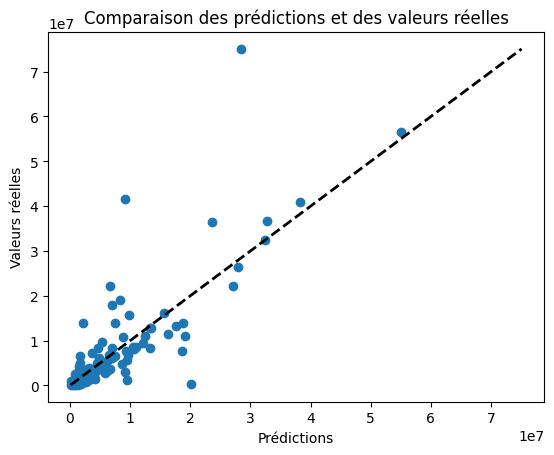

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004626,{'strategy': 'mean'}
1,SiteEnergyUse(kBtu),LinearRegression(fit_intercept=False),0.2613,6817892.8088,83486928297603.5469,0.008165,{'fit_intercept': False}
2,SiteEnergyUse(kBtu),"Lasso(alpha=100000.0, max_iter=10000, random_s...",0.6534,2430017.7020,39170430220874.3672,0.187429,{'alpha': 100000.0}
3,SiteEnergyUse(kBtu),"Ridge(alpha=71.96856730011514, random_state=42)",0.6471,2574982.9122,39885986077285.5938,0.009160,{'alpha': 71.96856730011514}
4,SiteEnergyUse(kBtu),"ElasticNet(alpha=0.3727593720314938, l1_ratio=...",0.6300,2673886.5652,41817911246886.8047,0.273776,"{'alpha': 0.3727593720314938, 'l1_ratio': 0.37..."
5,SiteEnergyUse(kBtu),"DecisionTreeRegressor(max_depth=5, min_samples...",0.5111,2711822.9877,55248793360970.8828,0.012610,"{'max_depth': 5, 'min_samples_leaf': 5}"
6,SiteEnergyUse(kBtu),(DecisionTreeRegressor(criterion='absolute_err...,0.5972,2460740.5346,45524550505914.6719,1.178947,"{'criterion': 'absolute_error', 'max_features'..."
7,SiteEnergyUse(kBtu),"XGBRegressor(base_score=0.5, booster='gbtree',...",0.6775,2567150.8454,36444709037842.6641,0.660242,{}


In [ ]:
parameters = {}

grid_xgboost_ghe = GridSearchCV(XGBoost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_xgboost_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_xgboost_ghe)

### LightBoost

lightboost = LGBMRegressor(random_state=42)
parameters = {'n_estimators': range(1000,1500,100),
            'learning_rate': [0.01,0.001,0.03,0.1,0.3]}

grid_lightboost_ghe = GridSearchCV(lightboost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lightboost_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_lgboost_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_lightboost_ghe)